In [11]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request 
import json
import time

## Meat Production

In [33]:
xlsx = pd.ExcelFile('data/meat_statistics.xlsx')

The original excel file was designed for human readable, including merged cells for the first category (a.k.a Commerical vs. Federally Inspected below) and then individual cells for the secondary category (a.k.a row 0). 

In [34]:
raw_data = pd.read_excel(xlsx, sheet_name = 'RedMeatPoultry_Prod-Full', header = 1)
raw_data.head()

,Type 1/,Commercial 2/,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Federally inspected,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,NaN,Beef 3/,Veal 3/,Pork 3/,Lamb and mutton 3/,NaN,Total red meat 3/ 4/,Beef 3/,Veal 3/,Pork 3/,Lamb and mutton 3/,Total red meat 3/ 4/,Broilers 5/,Other chicken 5/,Turkey 5/,Total poultry 4/ 5/ 6/,Total red meat and poultry 4/,NaN
1,Jan-Sep 2022,21237.3,40.2,20075.5,98.6,NaN,41451.6,20893.5,39.2,19983.1,87.6,41003.3,34348.1,424.116,3912.59,38787.7,79791,NaN
2,Jan-Sep 2021,20842.1,38.8,20489.8,103.1,NaN,41473.9,20490.1,37.7,20388.7,90.5,41007.3,33706.1,407.63,4192.11,38397.9,79405.2,NaN
3,Sep-2022,2390.9,4.2,2259.4,10.7,NaN,4665.2,2350.5,4.1,2247.7,9.6,4611.8,4003.83,45.102,420.551,4481.28,9093.08,NaN
4,Aug-2022,2506.5,4.7,2303.3,11.7,NaN,4826.1,2466.8,4.5,2291.1,10.3,4772.8,4210.98,55.285,449.156,4727.37,9500.17,NaN


There are two types - Commerical vs. Federally Inspected. Their numbers are pretty close. I decided to use the numbers under Federally Inspected because it contains more information in terms of meat types. 

In [35]:
idx = list(raw_data.columns).index('Federally inspected')
idxs = [0]
for i in range(len(raw_data.columns)):
    if i >= idx:
        idxs.append(i)

In [36]:
raw_data = raw_data.iloc[:, idxs]
raw_data.head()

,Type 1/,Federally inspected,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,NaN,Beef 3/,Veal 3/,Pork 3/,Lamb and mutton 3/,Total red meat 3/ 4/,Broilers 5/,Other chicken 5/,Turkey 5/,Total poultry 4/ 5/ 6/,Total red meat and poultry 4/,NaN
1,Jan-Sep 2022,20893.5,39.2,19983.1,87.6,41003.3,34348.1,424.116,3912.59,38787.7,79791,NaN
2,Jan-Sep 2021,20490.1,37.7,20388.7,90.5,41007.3,33706.1,407.63,4192.11,38397.9,79405.2,NaN
3,Sep-2022,2350.5,4.1,2247.7,9.6,4611.8,4003.83,45.102,420.551,4481.28,9093.08,NaN
4,Aug-2022,2466.8,4.5,2291.1,10.3,4772.8,4210.98,55.285,449.156,4727.37,9500.17,NaN


Replace the current header with the first row (a.k.a the secondary categories) and remove the empty column

In [37]:
new_header = raw_data.iloc[0, :-1]
raw_data = raw_data.iloc[1:, :-1]
raw_data.columns = new_header
raw_data.head()

,NaN,Beef 3/,Veal 3/,Pork 3/,Lamb and mutton 3/,Total red meat 3/ 4/,Broilers 5/,Other chicken 5/,Turkey 5/,Total poultry 4/ 5/ 6/,Total red meat and poultry 4/
1,Jan-Sep 2022,20893.5,39.2,19983.1,87.6,41003.3,34348.1,424.116,3912.59,38787.7,79791
2,Jan-Sep 2021,20490.1,37.7,20388.7,90.5,41007.3,33706.1,407.63,4192.11,38397.9,79405.2
3,Sep-2022,2350.5,4.1,2247.7,9.6,4611.8,4003.83,45.102,420.551,4481.28,9093.08
4,Aug-2022,2466.8,4.5,2291.1,10.3,4772.8,4210.98,55.285,449.156,4727.37,9500.17
5,Jul-2022,2214.4,4,1960.5,8.9,4187.8,3684.82,45.709,393.913,4134.36,8322.16


Transform the header by removing space and notation, explained below
- 1/ Excludes slaughter on farms.																
- 2/ Production in federally inspected and other plants.															
- 3/ Based on packers' dressed weights.																
- 4/ Totals may not add due to rounding.																
- 5/ Ready-to-cook.																
- 6/ Includes geese, guineas, ostriches, emus, rheas, squab, and other poultry.																

In [38]:
current_header = raw_data.columns[1:] 
transformed_header = ['Month']
for i in current_header:
    word = re.search('\D+', i).group().strip().replace(' ', '_')
    transformed_header.append(word.lower())
raw_data.columns = transformed_header
raw_data.head()

,Month,beef,veal,pork,lamb_and_mutton,total_red_meat,broilers,other_chicken,turkey,total_poultry,total_red_meat_and_poultry
1,Jan-Sep 2022,20893.5,39.2,19983.1,87.6,41003.3,34348.1,424.116,3912.59,38787.7,79791
2,Jan-Sep 2021,20490.1,37.7,20388.7,90.5,41007.3,33706.1,407.63,4192.11,38397.9,79405.2
3,Sep-2022,2350.5,4.1,2247.7,9.6,4611.8,4003.83,45.102,420.551,4481.28,9093.08
4,Aug-2022,2466.8,4.5,2291.1,10.3,4772.8,4210.98,55.285,449.156,4727.37,9500.17
5,Jul-2022,2214.4,4,1960.5,8.9,4187.8,3684.82,45.709,393.913,4134.36,8322.16


Remove the rows containing additional information

In [39]:
raw_data.tail(10)

,Month,beef,veal,pork,lamb_and_mutton,total_red_meat,broilers,other_chicken,turkey,total_poultry,total_red_meat_and_poultry
1222,Feb-1921,279,24,484,39,826,NaN,NaN,NaN,NaN,NaN
1223,Jan-1921,358,27,565,44,994,NaN,NaN,NaN,NaN,NaN
1224,1/ Excludes slaughter on farms.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1225,2/ Production in federally inspected and other...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1226,3/ Based on packers' dressed weights.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1227,4/ Totals may not add due to rounding.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1228,5/ Ready-to-cook.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1229,"6/ Includes geese, guineas, ostriches, emus, r...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1230,"Source: USDA, National Agricultural Statistics...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1231,Date run: 10/26/2022 7:51:13 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
trim_data = raw_data[~raw_data['Month'].str.contains('/ |Source|Date run')]
trim_data.tail()

,Month,beef,veal,pork,lamb_and_mutton,total_red_meat,broilers,other_chicken,turkey,total_poultry,total_red_meat_and_poultry
1219,May-1921,319,31,396,37,783,NaN,NaN,NaN,NaN,NaN
1220,Apr-1921,316,29,374,41,760,NaN,NaN,NaN,NaN,NaN
1221,Mar-1921,340,31,372,45,788,NaN,NaN,NaN,NaN,NaN
1222,Feb-1921,279,24,484,39,826,NaN,NaN,NaN,NaN,NaN
1223,Jan-1921,358,27,565,44,994,NaN,NaN,NaN,NaN,NaN


Drop columns for aggregation information and the type of `Other Chicken`

In [41]:
trim_data = trim_data.iloc[:, [0,1,2,3,4,6,8]]
trim_data.head()

,Month,beef,veal,pork,lamb_and_mutton,broilers,turkey
1,Jan-Sep 2022,20893.5,39.2,19983.1,87.6,34348.1,3912.59
2,Jan-Sep 2021,20490.1,37.7,20388.7,90.5,33706.1,4192.11
3,Sep-2022,2350.5,4.1,2247.7,9.6,4003.83,420.551
4,Aug-2022,2466.8,4.5,2291.1,10.3,4210.98,449.156
5,Jul-2022,2214.4,4,1960.5,8.9,3684.82,393.913


Keep only the monthly data and then convert to datetime data type

In [42]:
trim_data.head()

,Month,beef,veal,pork,lamb_and_mutton,broilers,turkey
1,Jan-Sep 2022,20893.5,39.2,19983.1,87.6,34348.1,3912.59
2,Jan-Sep 2021,20490.1,37.7,20388.7,90.5,33706.1,4192.11
3,Sep-2022,2350.5,4.1,2247.7,9.6,4003.83,420.551
4,Aug-2022,2466.8,4.5,2291.1,10.3,4210.98,449.156
5,Jul-2022,2214.4,4,1960.5,8.9,3684.82,393.913


In [43]:
meat_prod = trim_data.copy()
meat_prod = meat_prod[meat_prod['Month'].str.contains(r'\w{3}-\d{4}', regex=True)]
meat_prod.head()

,Month,beef,veal,pork,lamb_and_mutton,broilers,turkey
3,Sep-2022,2350.5,4.1,2247.7,9.6,4003.83,420.551
4,Aug-2022,2466.8,4.5,2291.1,10.3,4210.98,449.156
5,Jul-2022,2214.4,4,1960.5,8.9,3684.82,393.913
6,Jun-2022,2415.1,4.5,2245.1,10.2,3934.88,442.265
7,May-2022,2250.1,4.3,2171.9,9.6,3778.86,412.789


In [44]:
meat_prod['Month'] = meat_prod['Month'].apply(lambda x: datetime.strptime(x, '%b-%Y'))
meat_prod.head()

,Month,beef,veal,pork,lamb_and_mutton,broilers,turkey
3,2022-09-01,2350.5,4.1,2247.7,9.6,4003.83,420.551
4,2022-08-01,2466.8,4.5,2291.1,10.3,4210.98,449.156
5,2022-07-01,2214.4,4,1960.5,8.9,3684.82,393.913
6,2022-06-01,2415.1,4.5,2245.1,10.2,3934.88,442.265
7,2022-05-01,2250.1,4.3,2171.9,9.6,3778.86,412.789


In [45]:
meat_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1221 entries, 3 to 1223
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Month            1221 non-null   datetime64[ns]
 1   beef             985 non-null    object        
 2   veal             985 non-null    object        
 3   pork             985 non-null    object        
 4   lamb_and_mutton  985 non-null    object        
 5   broilers         753 non-null    object        
 6   turkey           753 non-null    object        
dtypes: datetime64[ns](1), object(6)
memory usage: 76.3+ KB


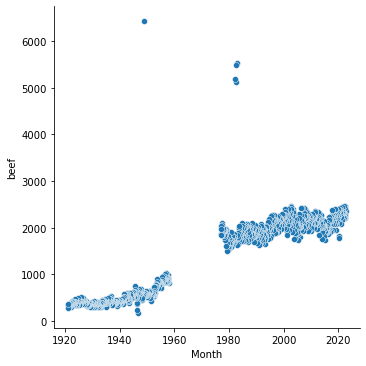

In [46]:
# outliers in 1982 and 1948, data unavailabe between 1957 and 1976
sns.relplot(data=meat_prod, x='Month', y = 'beef')

In [47]:
# 1982 some categories only have quartly data, 1948 December had no clear reasoning
meat_prod.loc[meat_prod['Month'].dt.year==1982, :]


,Month,beef,veal,pork,lamb_and_mutton,broilers,turkey
480,1982-12-01,5533,88,3515,91,971.294,192.737
481,1982-11-01,NaN,NaN,NaN,NaN,929.77,289.803
482,1982-10-01,NaN,NaN,NaN,NaN,1010.41,276.599
483,1982-09-01,5491,86,3139,86,1043.13,267.703
484,1982-08-01,NaN,NaN,NaN,NaN,1057.17,265.425
485,1982-07-01,NaN,NaN,NaN,NaN,1029.46,228.326
486,1982-06-01,5122,81,3443,83,1085.18,216.223
487,1982-05-01,NaN,NaN,NaN,NaN,1006.15,164.262
488,1982-04-01,NaN,NaN,NaN,NaN,1018.05,147.384
489,1982-03-01,5188,87,3560,89,1052.43,154.908


In [48]:
for i in ['beef', 'veal', 'pork', 'lamb_and_mutton']:
    meat_prod[i] = meat_prod.apply(lambda x: x[i]/3 if x['Month'].year==1982 else x[i], axis = 1)

meat_prod.loc[meat_prod['Month'].dt.year==1982, :]

,Month,beef,veal,pork,lamb_and_mutton,broilers,turkey
480,1982-12-01,1844.333333,29.333333,1171.666667,30.333333,971.294,192.737
481,1982-11-01,NaN,NaN,NaN,NaN,929.77,289.803
482,1982-10-01,NaN,NaN,NaN,NaN,1010.41,276.599
483,1982-09-01,1830.333333,28.666667,1046.333333,28.666667,1043.13,267.703
484,1982-08-01,NaN,NaN,NaN,NaN,1057.17,265.425
485,1982-07-01,NaN,NaN,NaN,NaN,1029.46,228.326
486,1982-06-01,1707.333333,27.000000,1147.666667,27.666667,1085.18,216.223
487,1982-05-01,NaN,NaN,NaN,NaN,1006.15,164.262
488,1982-04-01,NaN,NaN,NaN,NaN,1018.05,147.384
489,1982-03-01,1729.333333,29.000000,1186.666667,29.666667,1052.43,154.908


In [49]:
# split in 3 evenly and forward fill in missing data 
meat_prod = meat_prod.fillna(method='ffill', limit=2)

meat_prod.loc[meat_prod['Month'].dt.year==1982, :]

,Month,beef,veal,pork,lamb_and_mutton,broilers,turkey
480,1982-12-01,1844.333333,29.333333,1171.666667,30.333333,971.294,192.737
481,1982-11-01,1844.333333,29.333333,1171.666667,30.333333,929.770,289.803
482,1982-10-01,1844.333333,29.333333,1171.666667,30.333333,1010.407,276.599
483,1982-09-01,1830.333333,28.666667,1046.333333,28.666667,1043.129,267.703
484,1982-08-01,1830.333333,28.666667,1046.333333,28.666667,1057.168,265.425
485,1982-07-01,1830.333333,28.666667,1046.333333,28.666667,1029.465,228.326
486,1982-06-01,1707.333333,27.000000,1147.666667,27.666667,1085.177,216.223
487,1982-05-01,1707.333333,27.000000,1147.666667,27.666667,1006.147,164.262
488,1982-04-01,1707.333333,27.000000,1147.666667,27.666667,1018.048,147.384
489,1982-03-01,1729.333333,29.000000,1186.666667,29.666667,1052.427,154.908


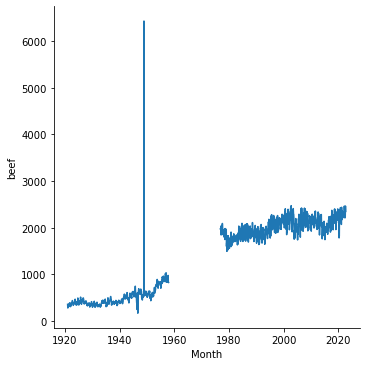

In [51]:
# smooth out the outliers in 1982, drop the outlier in 1948
sns.relplot(data=meat_prod, x='Month', y = 'beef', kind='line')

In [ ]:
# transform the data to visualize on one chart
meat_prod2 = pd.melt(meat_prod, id_vars=['Month'], value_vars=meat_prod.columns[1:])

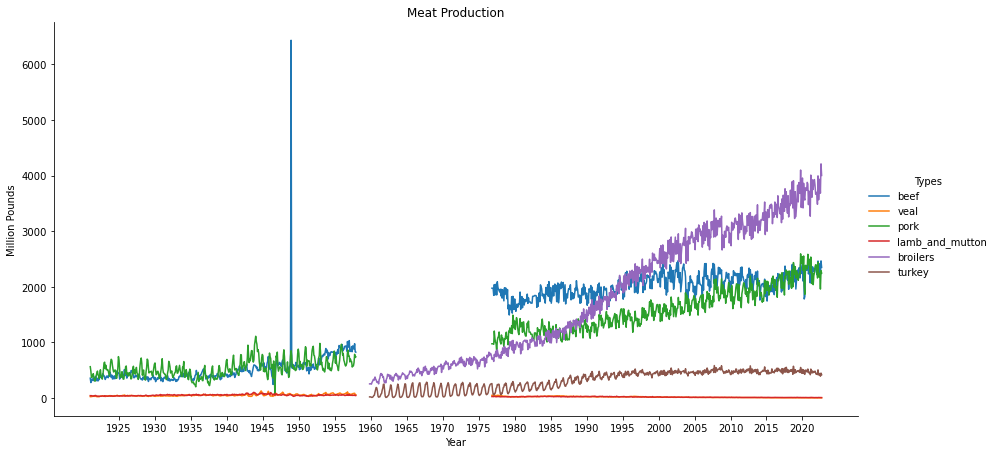

In [125]:
g = sns.relplot(data=meat_prod2.rename(columns={'variable':'Types'}), x='Month', y = 'value', 
                kind='line', hue='Types',height=6, aspect=2)
# extract yearly labels every five year
yearly_labels = sorted(list(meat_prod.loc[meat_prod['Month'].dt.month == 1, 'Month'].dt.year.astype(str)))
# display xtick labels every five year at 0 or 5
g.set(xticks=[yearly_labels[i+4] for i in range(0, len(yearly_labels)-4, 5)])
g.set(xticklabels=[yearly_labels[i+4] for i in range(0, len(yearly_labels)-4, 5)])
g.set(xlabel='Year', ylabel='Million Pounds')
g.set(title='Meat Production')

## Slaughter Counts

The original excel file was designed for human readable, including merged cells for the first category (a.k.a Commerical vs. Federally Inspected below) and then individual cells for the secondary category (a.k.a row 0). 

In [362]:
raw_data2 = pd.read_excel(xlsx, sheet_name = 'SlaughterCounts-Full', header = 1)
raw_data2.head()

,Type 1/,Commercial 2/,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33
0,NaN,Cattle,--Steers,--Heifers,NaN,--Beef cows,--Dairy cows,--Bulls and stags,Calves,Hogs,...,Hogs,--Barrows and gilts,--Sows,--Boars and stags,Sheep and lambs,--Lambs and yearlings,--Mature sheep,Broilers,Other chickens,Turkeys
1,Jan-Sep 2022,25828.6,12271.3,7807.01,NaN,2993.62,2322.08,434.578,274.2,93182.2,...,92707.1,90182.6,2299.3,225.1,1306,1223.3,82.7,7051011,85939,154857
2,Jan-Sep 2021,25316.5,12439.2,7427.12,NaN,2647.58,2384.55,418.095,284.2,95708,...,95181.6,92592.8,2359.2,229.9,1428.8,1321.9,106.6,6923989,87190,160589
3,Sep-2022,2898,1383.58,878.667,NaN,316.806,265.876,53.0732,30.8,10659,...,10597.2,10312.4,258.8,25.9,146.6,137.3,9.3,807091,9252,17188
4,Aug-2022,3076.3,1489.24,922.238,NaN,341.177,271.168,52.4809,34,10987.2,...,10922.2,10623,273.5,25.7,155.3,145.4,9.9,862696,10578,18334


There are two types - Commerical vs. Federally Inspected. Their numbers are pretty close. I decided to use the numbers under Federally Inspected because it contains more information in terms of meat types. 

In [363]:
idx = list(raw_data2.columns).index('Federally inspected 3/')
idxs = [0]
for i in range(len(raw_data2.columns)):
    if i >= idx:
        idxs.append(i)

In [364]:
raw_data2 = raw_data2.iloc[:, idxs]
print(raw_data2.shape)
raw_data2.head()

(1404, 18)


,Type 1/,Federally inspected 3/,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33
0,NaN,Cattle,--Steers,--Heifers,--Beef cows,--Dairy cows,--Bulls and stags,Calves,Hogs,--Barrows and gilts,--Sows,--Boars and stags,Sheep and lambs,--Lambs and yearlings,--Mature sheep,Broilers,Other chickens,Turkeys
1,Jan-Sep 2022,25330.4,12034.5,7656.4,2935.9,2277.2,426.2,268.7,92707.1,90182.6,2299.3,225.1,1306,1223.3,82.7,7051011,85939,154857
2,Jan-Sep 2021,24812.5,12191.7,7279.1,2594.9,2337,409.8,278.8,95181.6,92592.8,2359.2,229.9,1428.8,1321.9,106.6,6923989,87190,160589
3,Sep-2022,2839.4,1355.5,860.9,310.4,260.5,52,30.3,10597.2,10312.4,258.8,25.9,146.6,137.3,9.3,807091,9252,17188
4,Aug-2022,3018.8,1461.4,905,334.8,266.1,51.5,33.3,10922.2,10623,273.5,25.7,155.3,145.4,9.9,862696,10578,18334


Replace the current header with the first row (a.k.a the secondary categories) and remove the empty column

In [365]:
new_header = raw_data2.iloc[0, :]
raw_data2 = raw_data2.iloc[1:, :]
raw_data2.columns = new_header
raw_data2.head()

,NaN,Cattle,--Steers,--Heifers,--Beef cows,--Dairy cows,--Bulls and stags,Calves,Hogs,--Barrows and gilts,--Sows,--Boars and stags,Sheep and lambs,--Lambs and yearlings,--Mature sheep,Broilers,Other chickens,Turkeys
1,Jan-Sep 2022,25330.4,12034.5,7656.4,2935.9,2277.2,426.2,268.7,92707.1,90182.6,2299.3,225.1,1306,1223.3,82.7,7051011,85939,154857
2,Jan-Sep 2021,24812.5,12191.7,7279.1,2594.9,2337,409.8,278.8,95181.6,92592.8,2359.2,229.9,1428.8,1321.9,106.6,6923989,87190,160589
3,Sep-2022,2839.4,1355.5,860.9,310.4,260.5,52,30.3,10597.2,10312.4,258.8,25.9,146.6,137.3,9.3,807091,9252,17188
4,Aug-2022,3018.8,1461.4,905,334.8,266.1,51.5,33.3,10922.2,10623,273.5,25.7,155.3,145.4,9.9,862696,10578,18334
5,Jul-2022,2731.2,1299.4,827.7,327.3,230.1,46.7,28.9,9263.7,9000.2,237.6,25.9,132.9,123.6,9.4,758278,8993,16040


Transform the header by removing space and punctuations													

In [366]:
current_header = raw_data2.columns[1:] 
transformed_header = ['Month']
for i in current_header:
    word = re.search('[A-Z]\D+', i).group().strip().replace(' ', '_')
    transformed_header.append(word.lower())
raw_data2.columns = transformed_header
raw_data2.head()

,Month,cattle,steers,heifers,beef_cows,dairy_cows,bulls_and_stags,calves,hogs,barrows_and_gilts,sows,boars_and_stags,sheep_and_lambs,lambs_and_yearlings,mature_sheep,broilers,other_chickens,turkeys
1,Jan-Sep 2022,25330.4,12034.5,7656.4,2935.9,2277.2,426.2,268.7,92707.1,90182.6,2299.3,225.1,1306,1223.3,82.7,7051011,85939,154857
2,Jan-Sep 2021,24812.5,12191.7,7279.1,2594.9,2337,409.8,278.8,95181.6,92592.8,2359.2,229.9,1428.8,1321.9,106.6,6923989,87190,160589
3,Sep-2022,2839.4,1355.5,860.9,310.4,260.5,52,30.3,10597.2,10312.4,258.8,25.9,146.6,137.3,9.3,807091,9252,17188
4,Aug-2022,3018.8,1461.4,905,334.8,266.1,51.5,33.3,10922.2,10623,273.5,25.7,155.3,145.4,9.9,862696,10578,18334
5,Jul-2022,2731.2,1299.4,827.7,327.3,230.1,46.7,28.9,9263.7,9000.2,237.6,25.9,132.9,123.6,9.4,758278,8993,16040


Remove the rows containing additional information

In [367]:
raw_data2.tail(5)

,Month,cattle,steers,heifers,beef_cows,dairy_cows,bulls_and_stags,calves,hogs,barrows_and_gilts,sows,boars_and_stags,sheep_and_lambs,lambs_and_yearlings,mature_sheep,broilers,other_chickens,turkeys
1399,"slaughter are not official USDA, NASS data but...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1400,"Source: USDA, National Agricultural Statistics...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1401,"and USDA, ERS calculations for commercial slau...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1402,Date run: 10/26/2022 7:51:28 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [368]:
trim_data2 = raw_data2.dropna(thresh=3) # keep only rows containing 3+ observations
trim_data2.tail(5)

,Month,cattle,steers,heifers,beef_cows,dairy_cows,bulls_and_stags,calves,hogs,barrows_and_gilts,sows,boars_and_stags,sheep_and_lambs,lambs_and_yearlings,mature_sheep,broilers,other_chickens,turkeys
1387,May-1907,620,NaN,NaN,NaN,NaN,NaN,224,3317,NaN,NaN,NaN,769,NaN,NaN,NaN,NaN,NaN
1388,Apr-1907,635,NaN,NaN,NaN,NaN,NaN,205,2667,NaN,NaN,NaN,861,NaN,NaN,NaN,NaN,NaN
1389,Mar-1907,555,NaN,NaN,NaN,NaN,NaN,122,2665,NaN,NaN,NaN,842,NaN,NaN,NaN,NaN,NaN
1390,Feb-1907,570,NaN,NaN,NaN,NaN,NaN,99,2921,NaN,NaN,NaN,837,NaN,NaN,NaN,NaN,NaN
1391,Jan-1907,718,NaN,NaN,NaN,NaN,NaN,128,3410,NaN,NaN,NaN,1017,NaN,NaN,NaN,NaN,NaN


Keep columns for more common types

In [369]:
trim_data2 = trim_data2.iloc[:, [0,1,3,4,7,8,12,15,17]]
trim_data2.head()

,Month,cattle,heifers,beef_cows,calves,hogs,sheep_and_lambs,broilers,turkeys
1,Jan-Sep 2022,25330.4,7656.4,2935.9,268.7,92707.1,1306,7051011,154857
2,Jan-Sep 2021,24812.5,7279.1,2594.9,278.8,95181.6,1428.8,6923989,160589
3,Sep-2022,2839.4,860.9,310.4,30.3,10597.2,146.6,807091,17188
4,Aug-2022,3018.8,905,334.8,33.3,10922.2,155.3,862696,18334
5,Jul-2022,2731.2,827.7,327.3,28.9,9263.7,132.9,758278,16040


Keep only the monthly data and then convert to datetime data type

In [370]:
slau_count = trim_data2.copy()
slau_count = slau_count[slau_count['Month'].str.contains(r'\w{3}-\d{4}', regex=True)]
slau_count.head()

,Month,cattle,heifers,beef_cows,calves,hogs,sheep_and_lambs,broilers,turkeys
3,Sep-2022,2839.4,860.9,310.4,30.3,10597.2,146.6,807091,17188
4,Aug-2022,3018.8,905,334.8,33.3,10922.2,155.3,862696,18334
5,Jul-2022,2731.2,827.7,327.3,28.9,9263.7,132.9,758278,16040
6,Jun-2022,2984.8,891.1,352.2,28.6,10450.6,147.4,809283,18249
7,May-2022,2759.7,809.3,334.3,26.8,9985.7,138.3,780516,16579


In [371]:
slau_count['Month'] = slau_count['Month'].apply(lambda x: datetime.strptime(x, '%b-%Y'))
slau_count.head()

,Month,cattle,heifers,beef_cows,calves,hogs,sheep_and_lambs,broilers,turkeys
3,2022-09-01,2839.4,860.9,310.4,30.3,10597.2,146.6,807091,17188
4,2022-08-01,3018.8,905,334.8,33.3,10922.2,155.3,862696,18334
5,2022-07-01,2731.2,827.7,327.3,28.9,9263.7,132.9,758278,16040
6,2022-06-01,2984.8,891.1,352.2,28.6,10450.6,147.4,809283,18249
7,2022-05-01,2759.7,809.3,334.3,26.8,9985.7,138.3,780516,16579


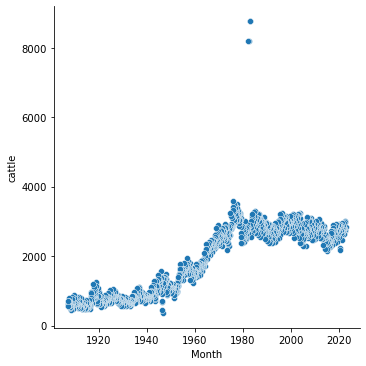

In [372]:
# outliers in 1982 
sns.relplot(data=slau_count, x='Month', y = 'cattle')

In [373]:
# 1982 some categories only have quartly data
slau_count.loc[slau_count['Month'].dt.year==1982, :]


,Month,cattle,heifers,beef_cows,calves,hogs,sheep_and_lambs,broilers,turkeys
480,1982-12-01,8762,2659,342,725.8,20068.2,1634.1,324325,11725
481,1982-11-01,NaN,NaN,339,NaN,NaN,NaN,312009,18546
482,1982-10-01,NaN,NaN,327,NaN,NaN,NaN,336440,17758
483,1982-09-01,8769.7,2740,292,692.3,18309.9,1577,351952,17799
484,1982-08-01,NaN,NaN,288,NaN,NaN,NaN,360424,17879
485,1982-07-01,NaN,NaN,270,NaN,NaN,NaN,352584,15310
486,1982-06-01,8192.4,2231,275,609.3,20042.7,1492.6,367476,14306
487,1982-05-01,NaN,NaN,258,NaN,NaN,NaN,338337,10888
488,1982-04-01,NaN,NaN,265,NaN,NaN,NaN,341112,9767
489,1982-03-01,8182.7,2203,276,701.9,20907.6,1569.7,357859,10693


In [374]:
for i in ['cattle', 'heifers', 'hogs', 'sheep_and_lambs']:
    slau_count[i] = slau_count.apply(lambda x: x[i]/3 if x['Month'].year==1982 else x[i], axis = 1)

slau_count.loc[slau_count['Month'].dt.year==1982, :]

,Month,cattle,heifers,beef_cows,calves,hogs,sheep_and_lambs,broilers,turkeys
480,1982-12-01,2920.666667,886.333333,342,725.8,6689.4,544.700000,324325,11725
481,1982-11-01,NaN,NaN,339,NaN,NaN,NaN,312009,18546
482,1982-10-01,NaN,NaN,327,NaN,NaN,NaN,336440,17758
483,1982-09-01,2923.233333,913.333333,292,692.3,6103.3,525.666667,351952,17799
484,1982-08-01,NaN,NaN,288,NaN,NaN,NaN,360424,17879
485,1982-07-01,NaN,NaN,270,NaN,NaN,NaN,352584,15310
486,1982-06-01,2730.800000,743.666667,275,609.3,6680.9,497.533333,367476,14306
487,1982-05-01,NaN,NaN,258,NaN,NaN,NaN,338337,10888
488,1982-04-01,NaN,NaN,265,NaN,NaN,NaN,341112,9767
489,1982-03-01,2727.566667,734.333333,276,701.9,6969.2,523.233333,357859,10693


In [375]:
# split in 3 evenly and forward fill in missing data 
slau_count = slau_count.fillna(method='ffill', limit=2)

slau_count.loc[slau_count['Month'].dt.year==1982, :]

,Month,cattle,heifers,beef_cows,calves,hogs,sheep_and_lambs,broilers,turkeys
480,1982-12-01,2920.666667,886.333333,342.0,725.8,6689.4,544.700000,324325.0,11725.0
481,1982-11-01,2920.666667,886.333333,339.0,725.8,6689.4,544.700000,312009.0,18546.0
482,1982-10-01,2920.666667,886.333333,327.0,725.8,6689.4,544.700000,336440.0,17758.0
483,1982-09-01,2923.233333,913.333333,292.0,692.3,6103.3,525.666667,351952.0,17799.0
484,1982-08-01,2923.233333,913.333333,288.0,692.3,6103.3,525.666667,360424.0,17879.0
485,1982-07-01,2923.233333,913.333333,270.0,692.3,6103.3,525.666667,352584.0,15310.0
486,1982-06-01,2730.800000,743.666667,275.0,609.3,6680.9,497.533333,367476.0,14306.0
487,1982-05-01,2730.800000,743.666667,258.0,609.3,6680.9,497.533333,338337.0,10888.0
488,1982-04-01,2730.800000,743.666667,265.0,609.3,6680.9,497.533333,341112.0,9767.0
489,1982-03-01,2727.566667,734.333333,276.0,701.9,6969.2,523.233333,357859.0,10693.0


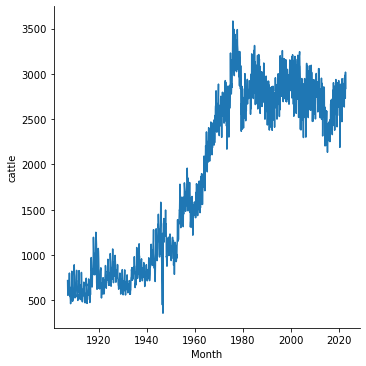

In [376]:
# smooth out the outliers in 1982, drop the outlier in 1948
sns.relplot(data=slau_count, x='Month', y = 'cattle', kind='line')

In [377]:
# transform the data to visualize on one chart
slau_count2 = pd.melt(slau_count, id_vars=['Month'], value_vars=slau_count.columns[1:])
slau_count2 = slau_count2.rename(columns={'variable':'Types'})

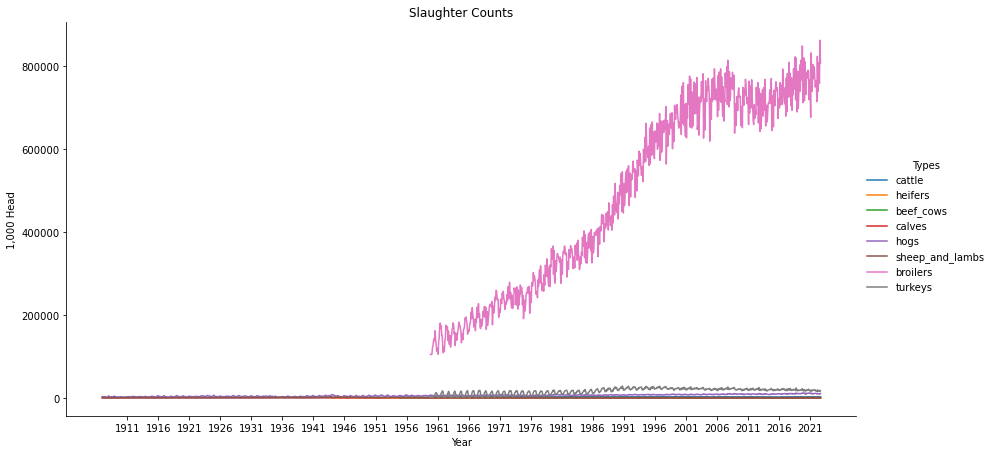

In [378]:
g = sns.relplot(data=slau_count2.rename(columns={'variable':'Types'}), x='Month', y = 'value', 
                kind='line', hue='Types',height=6, aspect=2)
# extract yearly labels every five year
yearly_labels = sorted(list(slau_count.loc[slau_count['Month'].dt.month == 1, 'Month'].dt.year.astype(str)))
# display xtick labels every five year at 0 or 5
g.set(xticks=[yearly_labels[i+4] for i in range(0, len(yearly_labels)-4, 5)])
g.set(xticklabels=[yearly_labels[i+4] for i in range(0, len(yearly_labels)-4, 5)])
g.set(xlabel='Year', ylabel='1,000 Head')
g.set(title='Slaughter Counts')

The count info cannot really tell the truth; try with the weight info.

## Slaughter Weights

The original excel file was designed for human readable, including merged cells for the first category (a.k.a Commerical vs. Federally Inspected below) and then individual cells for the secondary category (a.k.a row 0). 

In [396]:
raw_data3 = pd.read_excel(xlsx, sheet_name = 'SlaughterWeights-Full', header = 1)
raw_data3.head()

,Weight and species 1/,Commercial average live 2/,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Federally inspected average live,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 12,Federally inspected average dressed 3/,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,NaN,Cattle,Calves,Hogs,NaN,Sheep and lambs,Cattle,Calves,Hogs,Sheep and lambs,...,Turkeys,Cattle,Steers,NaN,Heifers,Cows,Bulls and stags,Calves,Hogs,Sheep and lambs
1,Jan-Sep 2022,1365.89,255.444,289.222,NaN,127.444,1368.89,253.333,289.222,132.667,...,31.58,827,905.111,NaN,831.889,633.778,878,147.333,215.667,67
2,Jan-Sep 2021,1366.78,238.333,287,NaN,122.222,1369.89,235.667,287,126.444,...,32.7211,827.889,900.333,NaN,827.889,641.333,892.556,137,214.222,63.5556
3,Sep-2022,1364,238,285,NaN,125,1368,236,285,129,...,30.46,830,915,NaN,834,615,867,137,212,65
4,Aug-2022,1348,242,282,NaN,127,1351,240,282,132,...,30.58,820,901,NaN,820,617,871,139,210,67


There are three types - `Commercial average live`, `Federally inspected average live`, and `Federally inspected average dressed`. Two average live numbers are pretty close and relatively higher than the average dressed numbers. I decided to use the numbers under Federally Inspected average live because it contains the critical category - broilers.

In [397]:
idx = list(raw_data3.columns).index('Federally inspected average live')
end_idx = list(raw_data3.columns).index('Federally inspected average dressed 3/')
idxs = [0]
for i in range(len(raw_data3.columns)):
    if i >= idx and i < end_idx:
        idxs.append(i)

In [398]:
raw_data3 = raw_data3.iloc[:, idxs]
print(raw_data3.shape)
raw_data3.head()

(1229, 8)


,Weight and species 1/,Federally inspected average live,Unnamed: 7,Unnamed: 8,Unnamed: 9,live,Unnamed: 11,Unnamed: 12
0,NaN,Cattle,Calves,Hogs,Sheep and lambs,Broilers,Other chickens,Turkeys
1,Jan-Sep 2022,1368.89,253.333,289.222,132.667,6.45222,6.99333,31.58
2,Jan-Sep 2021,1369.89,235.667,287,126.444,6.45111,6.80556,32.7211
3,Sep-2022,1368,236,285,129,6.57,7.01,30.46
4,Aug-2022,1351,240,282,132,6.47,7.33,30.58


Replace the current header with the first row (a.k.a the secondary categories) and remove the empty column

In [399]:
new_header = raw_data3.iloc[0, :]
raw_data3 = raw_data3.iloc[1:, :]
raw_data3.columns = new_header
raw_data3.head()

,NaN,Cattle,Calves,Hogs,Sheep and lambs,Broilers,Other chickens,Turkeys
1,Jan-Sep 2022,1368.89,253.333,289.222,132.667,6.45222,6.99333,31.58
2,Jan-Sep 2021,1369.89,235.667,287,126.444,6.45111,6.80556,32.7211
3,Sep-2022,1368,236,285,129,6.57,7.01,30.46
4,Aug-2022,1351,240,282,132,6.47,7.33,30.58
5,Jul-2022,1343,240,284,132,6.43,7.16,30.69


Transform the header by removing space and punctuations													

In [400]:
current_header = raw_data3.columns[1:] 
transformed_header = ['Month']
for i in current_header:
    word = re.search('\D+', i).group().strip().replace(' ', '_')
    transformed_header.append(word.lower())
raw_data3.columns = transformed_header
raw_data3.head()

,Month,cattle,calves,hogs,sheep_and_lambs,broilers,other_chickens,turkeys
1,Jan-Sep 2022,1368.89,253.333,289.222,132.667,6.45222,6.99333,31.58
2,Jan-Sep 2021,1369.89,235.667,287,126.444,6.45111,6.80556,32.7211
3,Sep-2022,1368,236,285,129,6.57,7.01,30.46
4,Aug-2022,1351,240,282,132,6.47,7.33,30.58
5,Jul-2022,1343,240,284,132,6.43,7.16,30.69


Remove the rows containing additional information

In [401]:
raw_data3.tail(5)

,Month,cattle,calves,hogs,sheep_and_lambs,broilers,other_chickens,turkeys
1224,1/ Excludes slaughter on farms.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1225,2/ Slaughter in federally inspected and other ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1226,3/ Weight of a chilled animal carcass.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1227,"Source: USDA, National Agricultural Statistics...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1228,Date run: 10/26/2022 7:51:39 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [402]:
trim_data3 = raw_data3.dropna(thresh=3) # keep only rows containing 3+ observations
trim_data3.tail(5)

,Month,cattle,calves,hogs,sheep_and_lambs,broilers,other_chickens,turkeys
1219,May-1921,1006,148,220,78,NaN,NaN,NaN
1220,Apr-1921,1013,137,226,85,NaN,NaN,NaN
1221,Mar-1921,1007,145,227,88,NaN,NaN,NaN
1222,Feb-1921,993,156,228,88,NaN,NaN,NaN
1223,Jan-1921,981,170,227,88,NaN,NaN,NaN


Keep columns for more common types

In [403]:
trim_data3 = trim_data3.iloc[:, [0,1,2,3,4,5,7]]
trim_data3.head()

,Month,cattle,calves,hogs,sheep_and_lambs,broilers,turkeys
1,Jan-Sep 2022,1368.89,253.333,289.222,132.667,6.45222,31.58
2,Jan-Sep 2021,1369.89,235.667,287,126.444,6.45111,32.7211
3,Sep-2022,1368,236,285,129,6.57,30.46
4,Aug-2022,1351,240,282,132,6.47,30.58
5,Jul-2022,1343,240,284,132,6.43,30.69


Keep only the monthly data and then convert to datetime data type

In [432]:
slau_avg_weight = trim_data3.copy()
slau_avg_weight = slau_avg_weight[slau_avg_weight['Month'].str.contains(r'\w{3}-\d{4}', regex=True)]
slau_avg_weight.head()

,Month,cattle,calves,hogs,sheep_and_lambs,broilers,turkeys
3,Sep-2022,1368,236,285,129,6.57,30.46
4,Aug-2022,1351,240,282,132,6.47,30.58
5,Jul-2022,1343,240,284,132,6.43,30.69
6,Jun-2022,1342,268,288,137,6.44,30.31
7,May-2022,1353,277,291,137,6.42,31.11


In [433]:
slau_avg_weight['Month'] = slau_avg_weight['Month'].apply(lambda x: datetime.strptime(x, '%b-%Y'))
slau_avg_weight.head()

,Month,cattle,calves,hogs,sheep_and_lambs,broilers,turkeys
3,2022-09-01,1368,236,285,129,6.57,30.46
4,2022-08-01,1351,240,282,132,6.47,30.58
5,2022-07-01,1343,240,284,132,6.43,30.69
6,2022-06-01,1342,268,288,137,6.44,30.31
7,2022-05-01,1353,277,291,137,6.42,31.11


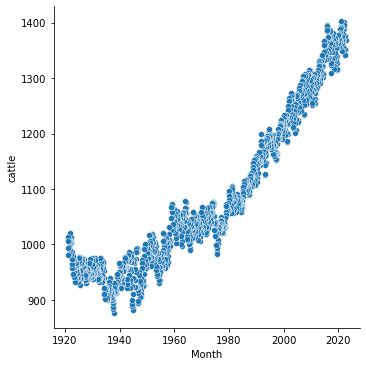

In [434]:
# no outliers because it is not aggregated like count or production
sns.relplot(data=slau_avg_weight, x='Month', y = 'cattle')

In [439]:
# transform the data to visualize on one chart
slau_avg_weight2 = pd.melt(slau_avg_weight, id_vars=['Month'], value_vars=slau_avg_weight.columns[1:])\
.rename(columns={'value':'average_weight', 'variable':'Types'})
# forward fill in missing value to get rid of nan values in the middle
slau_avg_weight2 = slau_avg_weight2.fillna(method='ffill', limit=2)

In [450]:
# combine average weight and count information
slau_weight = pd.merge(left = slau_avg_weight2, right = slau_count2.rename(columns={'value':'count'}), on = ['Month', 'Types'])
slau_weight.head()

,Month,Types,average_weight,count
0,2022-09-01,cattle,1368.0,2839.4
1,2022-08-01,cattle,1351.0,3018.8
2,2022-07-01,cattle,1343.0,2731.2
3,2022-06-01,cattle,1342.0,2984.8
4,2022-05-01,cattle,1353.0,2759.7


In [451]:
# calculate total weight
slau_weight['weight_in_thousands'] =  slau_weight['average_weight'] * slau_weight['count'] / 1000
slau_weight.head()

,Month,Types,average_weight,count,weight_in_thousands
0,2022-09-01,cattle,1368.0,2839.4,3884.2992
1,2022-08-01,cattle,1351.0,3018.8,4078.3988
2,2022-07-01,cattle,1343.0,2731.2,3668.0016
3,2022-06-01,cattle,1342.0,2984.8,4005.6016
4,2022-05-01,cattle,1353.0,2759.7,3733.8741


In [452]:
# drop rows containing any missing values
print(slau_weight.shape)
slau_weight2 = slau_weight.dropna()
print(slau_weight2.shape)

(7326, 5)
(6394, 5)


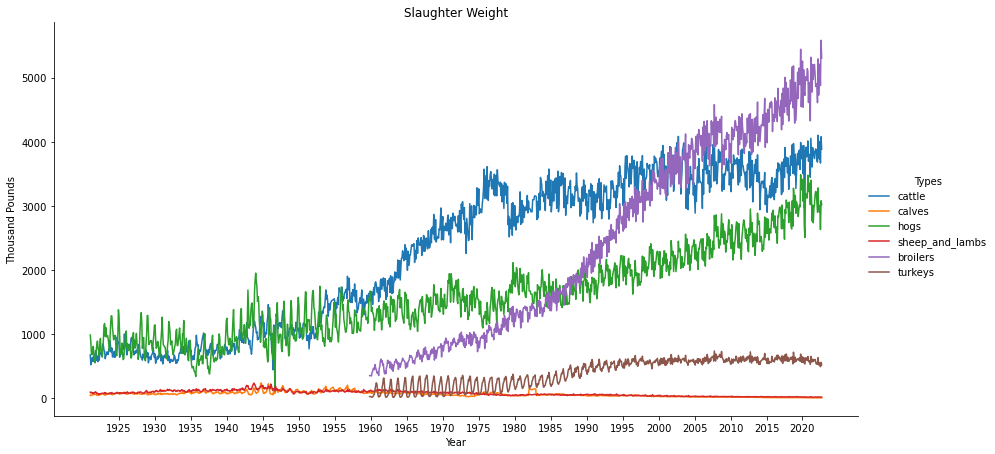

In [459]:
g = sns.relplot(data=slau_weight2, x='Month', y = 'weight_in_thousands', kind='line', hue='Types',height=6, aspect=2)
# extract yearly labels every five year
yearly_labels = sorted(list(slau_avg_weight.loc[slau_avg_weight['Month'].dt.month == 1, 'Month'].dt.year.astype(str)))
# display xtick labels every five year at 0 or 5
g.set(xticks=[yearly_labels[i+4] for i in range(0, len(yearly_labels)-4, 5)])
g.set(xticklabels=[yearly_labels[i+4] for i in range(0, len(yearly_labels)-4, 5)])
g.set(xlabel='Year', ylabel='Thousand Pounds')
g.set(title='Slaughter Weight')

## US Population (Census Data API)                       

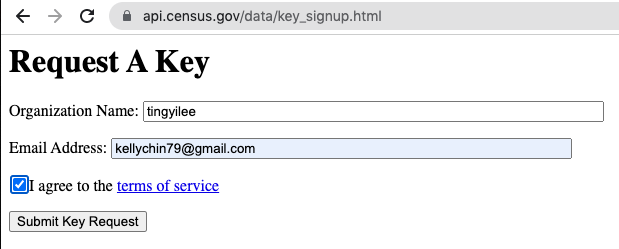

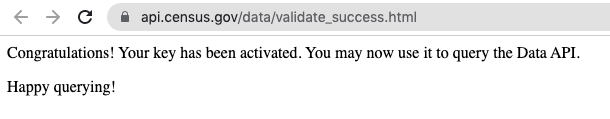

In [5]:
my_key = '6d04c5842f4f5fc4d6a4c68dfc07072389af07c8'

In [7]:
# 2000 Population Estimates - 2000-2010 Intercensal Estimates: National Monthly Population Estimates
# ONLY RETURN 2000-2010 DATA
api_link = 'http://api.census.gov/data/2000/pep/int_natmonthly?get=POP,MONTHLY_DESC&for=us:1&key={}'.format(my_key)
json_result = urllib.request.urlopen(api_link).read()
result1 = json.loads(json_result)
result1

[['POP', 'MONTHLY_DESC', 'us'],
 ['281424600', '4/1/2000 population estimates base', '1'],
 ['281643089', '5/1/2000 population estimate', '1'],
 ['281887481', '6/1/2000 population estimate', '1'],
 ['282162411', '7/1/2000 population estimate', '1'],
 ['282422213', '8/1/2000 population estimate', '1'],
 ['282693284', '9/1/2000 population estimate', '1'],
 ['282957962', '10/1/2000 population estimate', '1'],
 ['283197152', '11/1/2000 population estimate', '1'],
 ['283437649', '12/1/2000 population estimate', '1'],
 ['283647024', '1/1/2001 population estimate', '1'],
 ['283841797', '2/1/2001 population estimate', '1'],
 ['284047071', '3/1/2001 population estimate', '1'],
 ['284269299', '4/1/2001 population estimate', '1'],
 ['284487152', '5/1/2001 population estimate', '1'],
 ['284728443', '6/1/2001 population estimate', '1'],
 ['284968955', '7/1/2001 population estimate', '1'],
 ['285224368', '8/1/2001 population estimate', '1'],
 ['285493771', '9/1/2001 population estimate', '1'],
 ['28

In [ ]:
# Vintage Population Estimates: US, State, and PR Total Population and Components of Change (2013-2019)
# RETURN Annual Population Estimates. The reference date for all estimates is July 1
"""https://api.census.gov/data/2014/pep/natstprc?get=STNAME,POP&for=us:*&DATE_=7&key=6d04c5842f4f5fc4d6a4c68dfc07072389af07c8&key=6d04c5842f4f5fc4d6a4c68dfc07072389af07c8
api_link = 'http://api.census.gov/data/2000/pep/int_natmonthly?get=POP,MONTHLY_DESC&for=us:*&key={}'.format(my_key)
json_result = urllib.request.urlopen(api_link).read()
result = json.loads(json_result)
results.append(result)"""

In [12]:
# Current Population Survey: Basic Monthly (1989-2022)
# Count the records to get the population
results = []
for year in range(1989, 1995):
    print('Reading Year: {}...'.format(str(year)))
    api_link = 'https://api.census.gov/data/{}/cps/basic/apr?get=A_AGE&key={}'.format(str(year), my_key)
    json_result = urllib.request.urlopen(api_link).read()
    result = json.loads(json_result)
    results.append(result)
    time.sleep(1)
results[0:1]

Reading Year: 1989...
Reading Year: 1990...
Reading Year: 1991...
Reading Year: 1992...
Reading Year: 1993...
Reading Year: 1994...


HTTPError: HTTP Error 400: 

The variables in different years changed. Need to find a a more dynamic solution.

In [14]:
for i in results:
    print(len(i))

140441
150209
148822
145411
144944


ATTENTION! Above is only April, make sure to incorporate the month name in the API link as well.